In [1]:
from matplotlib import pyplot as plt
import matplotlib
from sklearn import preprocessing
import os
import numpy as np
import random as rd
import tensorflow as tf 
tf.compat.v1.disable_eager_execution()
sess  = tf.compat.v1.InteractiveSession()
from scipy.integrate import odeint
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy
import joblib

In [2]:
def model(x):
    a11, a12, a21, a22, gamma = np.array([0.7, 0, 0.8, 0.9, 0.6])
    x_f1 = a11*x[0] + a12*x[1]
    x_f2 = a21*x[0] + a22*x[1] + gamma*x[0]**2
    return [x_f1, x_f2]


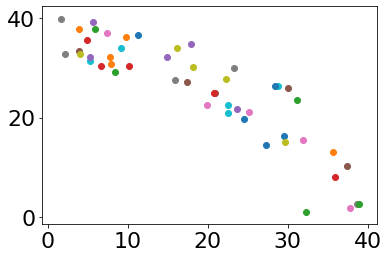

In [17]:
ICs = []
num_ics = 50
for i in range(0, num_ics):
    r = rd.uniform(30, 40)
    theta = rd.uniform(0, 0.5*3.14)
    ICs.append([r*np.cos(theta), r*np.sin(theta)])
    
for i in range(0, num_ics):
    plt.scatter(ICs[i][0],ICs[i][1])

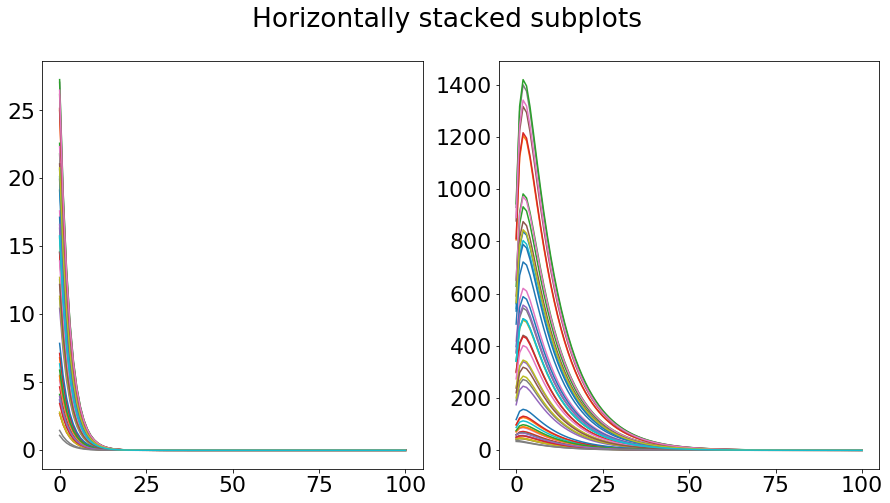

In [26]:
T = 100
matplotlib.rcParams.update({'font.size': 22})

t = np.linspace(0, T, T+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
fig.suptitle('Horizontally stacked subplots')
count = 0
for ic in ICs:
    x = np.array([ic[0], ic[1]])
    sol = []
    for i in range(0, T+1):
        y = model(x)
        x = y
        sol.append(x)
    if not count:
        Xp_data = np.array(sol[0:-1]).T
        Xf_data = np.array(sol[1:]).T
    else:
        #print("exec")
        Xp_data = np.hstack([Xp_data, np.array(sol[0:-1]).T])
        Xf_data = np.hstack([Xf_data, np.array(sol[1:]).T])        
    ax1.plot(t, np.array(sol).T[0])
    ax2.plot(t, np.array(sol).T[1])
    count+=1

In [40]:
Xf_data.shape[1]

5000

In [41]:
Xp=tf.compat.v1.placeholder(tf.compat.v1.double, shape = (2, Xp_data.shape[1]))

Xf=tf.compat.v1.placeholder(tf.compat.v1.double, shape = (2, Xf_data.shape[1]))

#n = tf.compat.v1.Variable(np.random.randn(), name = 'n', dtype = tf.double)
#n1 = tf.compat.v1.get_variable('n1',
#                   dtype=tf.double,
#                   shape=(),
#                   initializer=tf.random_uniform_initializer(minval=1., maxval=10.),
#                   constraint=lambda z: tf.clip_by_value(z, 1, 10))

n1 = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=3,stddev=0.3,dtype=tf.double))

#n1 = tf.Variable(1.0, dtype = tf.double)

Kx = tf.Variable(tf.compat.v1.truncated_normal((3, 3), mean=0.0,stddev=0.1,dtype=tf.double));
#np.abs(Y - W*b)


#last_col = tf.constant(np.zeros(shape=(3, 1)), dtype=tf.dtypes.double)

#last_col = tf.concat([last_col, [[1.]]], axis=0)

#Kx = tf.concat([Kx, last_col], axis=1)  
#print(Kx)




In [42]:
R2 = (1 - tf.divide(tf.math.reduce_sum(tf.math.square(tf.concat([Xf, [Xf[0]**n1]], axis = 0) - tf.math.reduce_mean(tf.concat([Xf, [Xf[0]**n1]], axis = 0), axis=0))), tf.math.reduce_sum(tf.math.square(tf.concat([Xf, [Xf[0]**n1]], axis = 0) - tf.matmul(Kx, tf.concat([Xf, [Xf[0]**n1]], axis = 0)))))) * 100

In [43]:
sess = tf.compat.v1.InteractiveSession();
sess.run(tf.compat.v1.global_variables_initializer());



In [44]:
cost = tf.reduce_sum(tf.pow(tf.concat([Xf, [Xf[0]**n1]], axis = 0) - tf.matmul(Kx, tf.concat([Xp, [Xp[0]**n1]], axis = 0)), 2))/len(Xp_data)

fwd_pred = tf.concat([Xp, [Xp[0]**tf.math.ceil(n1)]], axis = 0)
fwd_pred_first = Xp[0][0]**tf.math.ceil(n1)

In [46]:
init = tf.compat.v1.global_variables_initializer()
with tf.compat.v1.Session() as sesh:    
    # Initializing the Variables
    sesh.run(init)    
    print("Initial n1", sesh.run(R2, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)}))
    # Iterating through all the epochs

Initial n1 43.119043463716125


In [48]:
training_epochs = 85000
learning_rate = 0.00005
error_threshold = 0.000000001
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-08, use_locking=False, name='Adam').minimize(cost)
init = tf.compat.v1.global_variables_initializer()
c = 100
epoch = 0
with tf.compat.v1.Session() as sesh:    
    sesh.run(init)    
    print("Initial n1", sesh.run(n1))
    while epoch < training_epochs and c > error_threshold:
        c = sesh.run(cost, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)})
        if epoch % 5000 == 0:
            print("Epoch:", epoch, "{:.5f}".format(c))
            print("Exponent", sesh.run(n1))
            print("R2", sesh.run(R2, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)}))
        sesh.run(optimizer, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)})
        epoch+=1
    KxT_num = sesh.run(Kx)
    #sesh.close()
    print(sesh.run(n1))
    print(sesh.run(cost, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)}))

Initial n1 [2.79664811]
Epoch: 0 159390232.05984
Exponent [2.79664811]
R2 54.62967423961658
Epoch: 5000 30736722.32483
Exponent [2.56394367]
R2 -18.79942702333608
Epoch: 10000 9245462.33261
Exponent [2.32484966]
R2 -234.82924274400224
Epoch: 15000 914760.77651
Exponent [2.07845136]
R2 -1623.31191063846
Epoch: 20000 0.15129
Exponent [1.99751921]
R2 -6743.22070785239
Epoch: 25000 0.00177
Exponent [2.00000012]
R2 -6711.357804652231
Epoch: 30000 0.00106
Exponent [2.00000003]
R2 -6711.480077686116
Epoch: 35000 0.00052
Exponent [2.00000044]
R2 -6711.430976331131
Epoch: 40000 0.00102
Exponent [2.00000061]
R2 -6711.507238714084
Epoch: 45000 0.00029
Exponent [2.00000026]
R2 -6711.427416300889
Epoch: 50000 0.00162
Exponent [2.00000305]
R2 -6711.559616705159
Epoch: 55000 0.00008
Exponent [2.00000036]
R2 -6711.35709630648
Epoch: 60000 0.00029
Exponent [1.99999965]
R2 -6711.327824919731
Epoch: 65000 0.00093
Exponent [1.99999998]
R2 -6711.207377226087
Epoch: 70000 0.00047
Exponent [1.99999962]
R2 -6

In [39]:
Xp

<tf.Tensor 'Placeholder_2:0' shape=(2, 2) dtype=float64>

In [12]:
KxT_num

array([[ 6.99997898e-01, -2.10181966e-06, -2.10174692e-06],
       [ 8.00139337e-01,  9.00000221e-01,  5.99958746e-01],
       [-2.38573870e-06, -2.48451384e-06,  4.89993975e-01]])

## Discrete model

In [ ]:
model_name = 'CFS_data'

In [ ]:
scaler = StandardScaler().fit(Xp)
Xp_ref_scaled = np.array(Xp)#scaler.transform(Xp)
Xf_ref_scaled = np.array(Xf)#scaler.transform(Xf)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.scatter(np.linspace(0, len(Xp_ref_scaled[:, 0]), len(Xp_ref_scaled[:, 0])), Xp_ref_scaled[:, 0], color = 'r')
ax1.scatter(np.linspace(1, len(Xf_ref_scaled[:, 0])+1, len(Xf_ref_scaled[:, 0])), Xf_ref_scaled[:, 0], color = 'b')

ax1.set_xlim([-2, 22])
ax1.set_ylim([-5, 5])

ax2.scatter(np.linspace(0, len(Xp_ref_scaled[:, 1]), len(Xp_ref_scaled[:, 1])), Xp_ref_scaled[:, 1], color = 'r')
ax2.scatter(np.linspace(1, len(Xf_ref_scaled[:, 1])+1, len(Xf_ref_scaled[:, 1])), Xf_ref_scaled[:, 1], color = 'b')

#ax2.set_xlim([-2, 22])
#ax2.set_ylim([-5, 5])

scaler_filename = "CFS_scaler.save"
joblib.dump(scaler, scaler_filename) 

In [ ]:
PsiXp = np.vstack([Xp_ref_scaled.T, Xp_ref_scaled.T[0]**2.0])
PsiXf = np.vstack([Xf_ref_scaled.T, Xf_ref_scaled.T[0]**2.0])

In [ ]:
Kx = np.matmul(PsiXf, np.matmul(PsiXp.T, np.linalg.inv(np.matmul(PsiXp, PsiXp.T))))

In [ ]:
Kx

In [ ]:
np.sum((PsiXf - np.matmul(Kx, PsiXp))**2)

In [ ]:
import joblib

scaler_filename = 'CFS_scaler.save'
scaler = joblib.load(scaler_filename) 

P = np.diag(scaler.scale_)
b = scaler.mean_

K11 = np.array([[0.7, 0], [0.8, 0.9]])
K12 = np.array([[0], [0.6]])
K21 = np.array([[0, 0]])
K22 = np.array([[0.49]])

Ks11 = np.matmul(np.matmul(P, K11), np.linalg.inv(P))
Ks12 = np.matmul(P, K12)
Ks13 = np.matmul(np.eye(2) - Ks11, b)
Ks21 = np.matmul(K21, np.linalg.inv(P))
Ks22 = K22
Ks23 = np.matmul(Ks21, b)

Ks1 = np.concatenate([Ks11, Ks12, Ks13.reshape(-1, 1)], axis = 1)
Ks2 = np.concatenate([Ks21, Ks22, Ks23.reshape(-1, 1)], axis = 1)
Ks = np.concatenate([Ks1, Ks2, np.array([[0, 0, 0, 1]])], axis = 0)

Ks

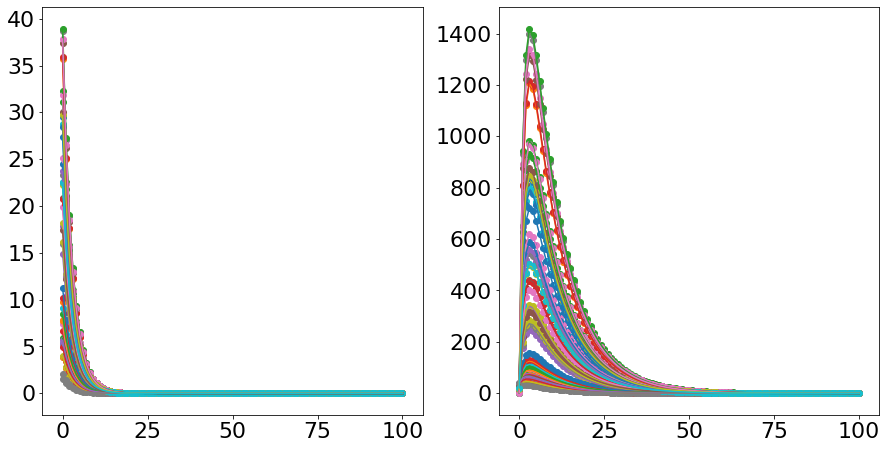

In [56]:
Xp_final_learned = []
Xf_final_learned = []
Xp_final_actual = []
Xf_final_actual = []
#t = np.array([i for i in range(0, N+1)])
x_learned = np.zeros(2)
x_actual = np.zeros(2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
#fig.suptitle('Horizontally stacked subplots')
T = 100
t = np.linspace(0, T, T+1)

for ic in ICs:
    #ic_s = scaler.transform(np.array([ic]))
    x_learned = np.array(ic)
    x_actual[0] = ic[0]
    x_actual[1] = ic[1]
    X_learned = []
    #print("x_actual", x_actual)
    #print("x_learned", x_learned)
    X_actual = []
    X_learned.append([x_learned[0], x_learned[1]]) ## ICs
    X_actual.append(np.array([x_actual[0], x_actual[1]])) 
    for k in range(0, T):
        y_learned = np.matmul(KxT_num, np.vstack([x_learned[0], x_learned[1], x_learned[0]**2]))#[0:2].T[0]
        x_learned = y_learned#np.array([[y_learned[0], y_learned[1]]])
        X_learned.append([x_learned[0], x_learned[1]]) 
        y_actual = model(x_actual)
        x_actual = y_actual
        X_actual.append(x_actual)
    ax1.scatter(t, np.array(X_actual).T[0])
    ax1.plot(t, np.array(X_learned).T[0])
    ax2.scatter(t, np.array(X_actual).T[1])
    ax2.plot(t, np.array(X_learned).T[1])

In [57]:
X_learned

[[22.519424949723394, 20.87802441605382],
 [array([15.76353403]), array([341.07995632])],
 [array([11.03440406]), array([468.67564457])],
 [array([7.72401352]), array([503.68990826])],
 [array([5.40674364]), array([495.29584946])],
 [array([3.78465947]), array([467.6309135])],
 [array([2.64920564]), array([432.48930596])],
 [array([1.85439299]), array([395.5703211])],
 [array([1.29802889]), array([359.55971116])],
 [array([0.90857844]), array([325.65276847])],
 [array([0.63596717]), array([294.30937243])],
 [array([0.44514298]), array([265.62961916])],
 [array([0.31156939]), array([239.54142653])],
 [array([0.21807092]), array([215.89457161])],
 [array([0.15262473]), array([194.5079122])],
 [array([0.10681487]), array([175.19302449])],
 [array([0.0747502]), array([157.76586393])],
 [array([0.05230695]), array([142.05229011])],
 [array([0.03659849]), array([127.8904221])],
 [array([0.0256042]), array([115.13134877])],
 [array([0.01790966]), array([103.63898835])],
 [array([0.01252482]),

In [55]:
np.matmul(KxT_num, np.vstack([x_learned[0], x_learned[1], x_learned[0]**2]))

array([[-1.17506555e-08],
       [ 2.03899784e-02],
       [-5.79267154e-08]])

In [58]:
KxT_num

array([[ 6.99999885e-01, -1.15258466e-07, -1.15225481e-07],
       [ 7.99998975e-01,  8.99999112e-01,  5.99999085e-01],
       [-2.56177671e-06, -2.55684410e-06,  4.89997436e-01]])